# Process notes

## Data sources

### AnalyzeBoston
[AnalyzeBoston](https://data.boston.gov/) has over 200 datasets pertaining to the city, varying in topic, size, and update frequency. 
While downloading a .csv manually works, some datasets are updated frequently enough that downloads may become stale. However, an API endpoint is accessible that allows for up-to-date access.

- In regards to this project, there are a few core datasets:
    - [Employee Earnings Reports](https://data.boston.gov/dataset/employee-earnings-report) *(static by year)*
    
    - [Field Interrogation and Observation Data](https://data.boston.gov/dataset/boston-police-department-fio) *(updated weekly)*
    
    - [Checkbook Explorer](https://data.boston.gov/dataset/checkbook-explorer) *(updated monthly)*
    
    - [Crime Incident Reports](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system) *(updated daily)*
    
#### Analyze Boston API
- Each database is represented using a resource ID formatted as;
  - xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx
- Below is a function which returns a dictionary of some relevant ones.


In [3]:
def getSourceDict():
    sources = {"CRIMEINCIDENTREPORTS_2022": "313e56df-6d77-49d2-9c49-ee411f10cf58",
                "CRIMEINCIDENTREPORTS_2021": "f4495ee9-c42c-4019-82c1-d067f07e45d2",
                "CRIMEINCIDENTREPORTS_2020": "be047094-85fe-4104-a480-4fa3d03f9623",
                "CRIMEINCIDENTREPORTS_2019": "34e0ae6b-8c94-4998-ae9e-1b51551fe9ba",
                "CRIMEINCIDENTREPORTS_2018": "e86f8e38-a23c-4c1a-8455-c8f94210a8f1",
                "SHOOTINGS": "313e56df-6d77-49d2-9c49-ee411f10cf58",
                "SHOTSFIRED": "e16705ca-49ce-4803-84c1-c9848aa63024",
                "FIELDINTERROGATION_2020": "64dd32d9-26f9-4275-9265-97fa3de7e22b",
                "FIELDINTERROGATION_2019": "03f33240-47c1-46f2-87ae-bcdabec092ad",
                "FIELDINTERROGATION_2016": "35f3fb8f-4a01-4242-9758-f664e7ead125",
                "FIREARM_RECOVERY": "a3d2260f-8a41-4e95-9134-d14711b0f954",
                "EARNINGS_2021": "ec5aaf93-1509-4641-9310-28e62e028457",
                "EARNINGS_2020": "e2e2c23a-6fc7-4456-8751-5321d8aa869b",
                "EARNINGS_2019": "3bdfe6dc-3a81-49ce-accc-22161e2f7e74",
                "EARNINGS_2018": "31358fd1-849a-48e0-8285-e813f6efbdf1",
                "CHECKBOOK_2022": "0a261d4e-3eec-4bac-bf72-b9a7aa77b033",
                "CHECKBOOK_2021": "32897eeb-d9ca-494f-93b1-991c50bcd6a6"
                }
    return(sources)

- Using the [requests](https://pypi.org/project/requests/) library, these databases can be accessed directly

In [4]:
import requests

- A helper function to handle converting the name of the database into the RID, and a helper function to list the names of all the sources

In [5]:
def sourcetorid(sourcename):
    rid = getSourceDict()[sourcename]
    return(rid)
def list_sources():
    sourcelist=[]
    q = getSourceDict()
    for key in q:
        sourcelist.append(key)
    return(sourcelist)

- Some basic queries:

In [6]:
#resource id, int n -> json (results which are the first n)
def n_recent(rid, n):
    r = requests.get("https://data.boston.gov/api/3/action/datastore_search?resource_id="+rid+"&limit="+str(n))
    return(r.json())


#resource id, string n -> json (results which are those which contain n)
def n_contained(rid, n):
    r = requests.get("https://data.boston.gov/api/3/action/datastore_search?resource_id="+rid+"&q="+str(n))
    return(r.json())


#resource id, int r (the number of results to return), int n (the starting index) -> json (results which start at n, go to n+r)
def n_skip(rid, r, n):
    r = requests.get("https://data.boston.gov/api/3/action/datastore_search?resource_id="+rid+"$top=",r,"&$skip=",n)
    return(r.json())


- Two functions to parse the returned json(s):

In [7]:
#request json -> list of fields in the result w/ types and names
def return_fields(returnedjson):
    return(returnedjson['result']['fields'])


#request result -> nice format to parse
def eat_result(eson):
    re = eson['result']['records']
    return(re)

- Requesting the data (example):

In [8]:
    sourcenames = list_sources()
    print("==== Available sources: ====")
    for x in range(0, len(sourcenames)):
        print(sourcenames[x])

==== Available sources: ====
CRIMEINCIDENTREPORTS_2022
CRIMEINCIDENTREPORTS_2021
CRIMEINCIDENTREPORTS_2020
CRIMEINCIDENTREPORTS_2019
CRIMEINCIDENTREPORTS_2018
SHOOTINGS
SHOTSFIRED
FIELDINTERROGATION_2020
FIELDINTERROGATION_2019
FIELDINTERROGATION_2016
FIREARM_RECOVERY
EARNINGS_2021
EARNINGS_2020
EARNINGS_2019
EARNINGS_2018
CHECKBOOK_2022
CHECKBOOK_2021


- Selecting and pulling the fields (the column names) of a desired source:

In [9]:
selected="EARNINGS_2021"
rid = sourcetorid(selected)
rid_fields = return_fields(n_recent(rid, 1))
print("== ", rid,"(",selected, ")", " fields: ==")
for x in range(0, len(rid_fields)):
    print(rid_fields[x])

==  ec5aaf93-1509-4641-9310-28e62e028457 ( EARNINGS_2021 )  fields: ==
{'type': 'int', 'id': '_id'}
{'type': 'text', 'id': 'NAME'}
{'type': 'text', 'id': 'DEPARTMENT_NAME'}
{'type': 'text', 'id': 'TITLE'}
{'type': 'text', 'id': 'REGULAR'}
{'type': 'text', 'id': 'RETRO'}
{'type': 'text', 'id': 'OTHER'}
{'type': 'text', 'id': 'OVERTIME'}
{'type': 'text', 'id': 'INJURED'}
{'type': 'text', 'id': 'DETAIL'}
{'type': 'text', 'id': 'QUINN_EDUCATION_INCENTIVE'}
{'type': 'text', 'id': 'TOTAL_GROSS'}
{'type': 'text', 'id': 'POSTAL'}


- Getting the first <i>n</i> entries from the dataset:

In [10]:
n = 5
print("== Requesting ", str(n), "entries from ", rid, " ==")
print("")
re = eat_result(n_recent(rid, n))
for re_iterator in range(0, len(re)):
    print(str(re[re_iterator]) + '\n')

== Requesting  5 entries from  ec5aaf93-1509-4641-9310-28e62e028457  ==

{'INJURED': None, 'POSTAL': '02119', 'NAME': 'Beckers,Richard', 'TITLE': 'Police Officer', 'DETAIL': None, 'OTHER': '1,264,843.63', 'DEPARTMENT_NAME': 'Boston Police Department', 'OVERTIME': None, 'REGULAR': None, 'RETRO': None, 'TOTAL_GROSS': '1,264,843.63', '_id': 1, 'QUINN_EDUCATION_INCENTIVE': None}

{'INJURED': None, 'POSTAL': '02129', 'NAME': 'McGowan,Jacqueline M.', 'TITLE': 'Police Officer', 'DETAIL': None, 'OTHER': '1,252,990.81', 'DEPARTMENT_NAME': 'Boston Police Department', 'OVERTIME': None, 'REGULAR': None, 'RETRO': None, 'TOTAL_GROSS': '1,252,990.81', '_id': 2, 'QUINN_EDUCATION_INCENTIVE': None}

{'INJURED': '30,939.24', 'POSTAL': '02130', 'NAME': 'Harris,Shawn N', 'TITLE': 'Police Offc Comm Serv Offc 3$8', 'DETAIL': '12,144.00', 'OTHER': '212,739.48', 'DEPARTMENT_NAME': 'Boston Police Department', 'OVERTIME': '82,300.87', 'REGULAR': '69,772.10', 'RETRO': None, 'TOTAL_GROSS': '433,073.75', '_id': 3, 

## Formatting and Storing the data

### Formatting
- The data must be cleaned for use in libraries and passed to a datatype
- Two popular options, often best used in conjunction, are the [numpy](https://pypi.org/project/numpy/) matrix; 

In [11]:

import numpy as np
n = 100000
selected="EARNINGS_2021"

rid = sourcetorid(selected)
rid_fields = return_fields(n_recent(rid, 1))
rid_names = []
rid_types = []
for x in range(0, len(rid_fields)):
    rid_names.append(rid_fields[x]['id'])
    rid_types.append(rid_fields[x]['type'])
re = eat_result(n_recent(rid, n))
our_array = []
for re_iterator in range(0, len(re)):
    iterating_list = []
    for name in rid_names:
        current_type = rid_types[rid_names.index(name)]
        #patching 'None'
        if(re[re_iterator][name] is None):
            re[re_iterator][name] = "None"
        #some string cleaning and correction of incorrectly labelled fields
        if(str(re[re_iterator][name]).replace(",","").replace(".","").isnumeric()):
            re[re_iterator][name]=str(re[re_iterator][name]).replace(",","")
            current_type = "int"
        if(current_type == "text"):
            iterating_list.append(str(re[re_iterator][name]))
        if(current_type == "int"):
            re[re_iterator][name]=str(re[re_iterator][name]).replace(",","")
            iterating_list.append(float(re[re_iterator][name]))
    iterating_list = np.array(iterating_list)
    our_array.append(iterating_list)
our_array = np.array(our_array)
print(rid_names)
print(our_array)
#asserting that we have an n long array with the same number of columns as 
#field names
#assert our_array.shape[0] == n
assert our_array.shape[1] == len(rid_names)

print(our_array.shape)

['_id', 'NAME', 'DEPARTMENT_NAME', 'TITLE', 'REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN_EDUCATION_INCENTIVE', 'TOTAL_GROSS', 'POSTAL']
[['1.0' 'Beckers,Richard' 'Boston Police Department' ... 'None'
  '1264843.63' '2119.0']
 ['2.0' 'McGowan,Jacqueline M.' 'Boston Police Department' ... 'None'
  '1252990.81' '2129.0']
 ['3.0' 'Harris,Shawn N' 'Boston Police Department' ... '25178.06'
  '433073.75' '2130.0']
 ...
 ['22546.0' 'Smith,Wayne Lee' 'Boston Public Library' ... 'None' '26.0'
  '2121.0']
 ['22551.0' 'None' 'None' ... 'None' 'None' 'None']
 ['22552.0' 'None' 'None' ... 'None' 'None' 'None']]
(22552, 13)


- and the [pandas](https://pypi.org/project/pandas/) dataframe 

In [12]:
import pandas as pd

our_dataframe = pd.DataFrame(data=our_array, columns=rid_names)
print(our_dataframe.head())

   _id                   NAME           DEPARTMENT_NAME  \
0  1.0        Beckers,Richard  Boston Police Department   
1  2.0  McGowan,Jacqueline M.  Boston Police Department   
2  3.0         Harris,Shawn N  Boston Police Department   
3  4.0      Washington,Walter  Boston Police Department   
4  5.0      Mosley Jr.,Curtis  Boston Police Department   

                            TITLE    REGULAR RETRO       OTHER  OVERTIME  \
0                  Police Officer       None  None  1264843.63      None   
1                  Police Officer       None  None  1252990.81      None   
2  Police Offc Comm Serv Offc 3$8    69772.1  None   212739.48  82300.87   
3                  Police Officer  100963.38  None   211900.28  67849.66   
4  Police Offc Comm Serv Offc 3$8  109858.02  None   192097.54  75938.65   

    INJURED   DETAIL QUINN_EDUCATION_INCENTIVE TOTAL_GROSS  POSTAL  
0      None     None                      None  1264843.63  2119.0  
1      None     None                      None  12

### Storing
- As the data may be updated, changed, accessed in portions, and combined, the fan-favorite .csv may not be ideal, with abysmal reading and writing times. It remains an option, but not the best one. 
- Another option is the [.h5](https://www.pytables.org/cookbook/inmemory_hdf5_files.html) file, which offers significant improvements in read and write time and allows for in-memory editing.

### Cleaning and preparing to visualize


In [13]:


departments = our_dataframe['DEPARTMENT_NAME']
salaries = our_dataframe["OVERTIME"]
title = our_dataframe["TITLE"]
title = our_dataframe["INJURED"]
regular_salaries = our_dataframe["REGULAR"]
overtime_salaries = our_dataframe["OVERTIME"]
salaries_per_department = {}
for x in range(0, len(departments)):
    if("BPS" in departments[x] or "K-8" in departments[x] or "Academy" in departments[x] or "Elementary" in departments[x] or "Learning" in departments[x]):
        departments[x]="Education"
    if(departments[x]!="None" and salaries[x]!="None"):
        if(not(departments[x] in salaries_per_department)):
            salaries_per_department[departments[x]] = [float(salaries[x])]
        elif((departments[x] in salaries_per_department)):
            salaries_per_department[departments[x]].append(float(salaries[x]))

## Visualizing the data

### Scattering the salaries by department, 

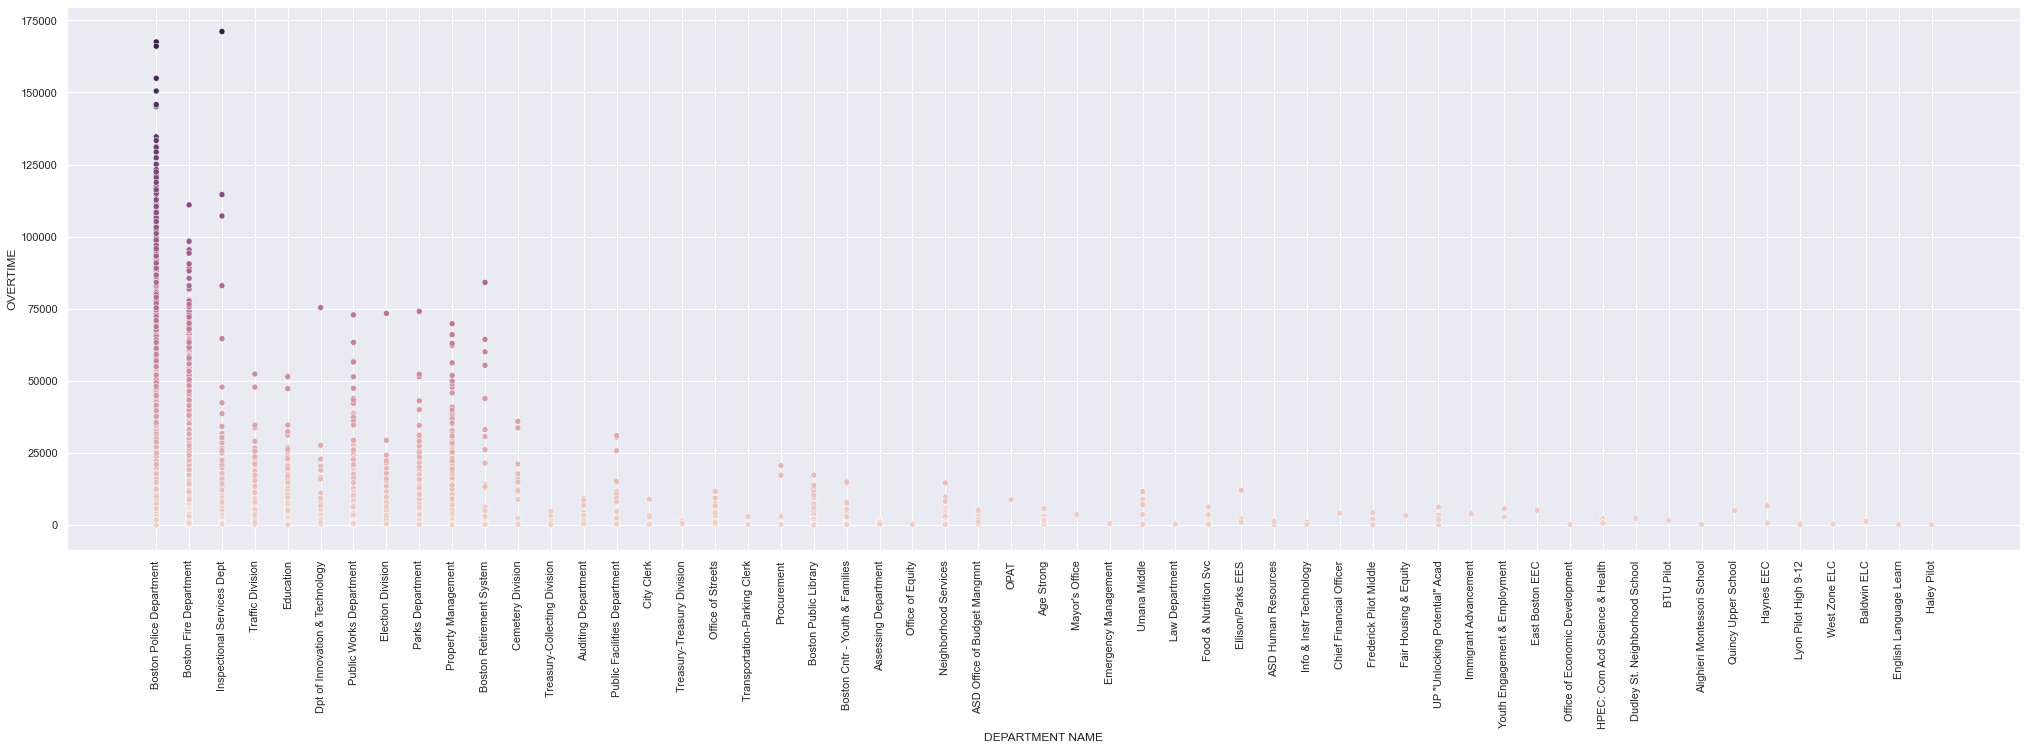

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

points = []
points_summed = []
for x in salaries_per_department:
    summation=0
    for y in range(0, len(salaries_per_department[x])):
        summation+=salaries_per_department[x][y]
        point = [x, salaries_per_department[x][y]]
        points.append(point)
    points_summed.append([x, summation])
        
our_cleaned_dataframe = pd.DataFrame(points, columns=["DEPARTMENT NAME", "OVERTIME"])
our_cleaned_sum_dataframe = pd.DataFrame(points_summed, columns=["DEPARTMENT NAME", "SUM SALARY PAYOUT"])


plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(45,20)})
sns.scatterplot(data=our_cleaned_dataframe, x="DEPARTMENT NAME", y="OVERTIME", hue="OVERTIME",legend = False)
plt.show()

#to add a legend: set legend = True;
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)





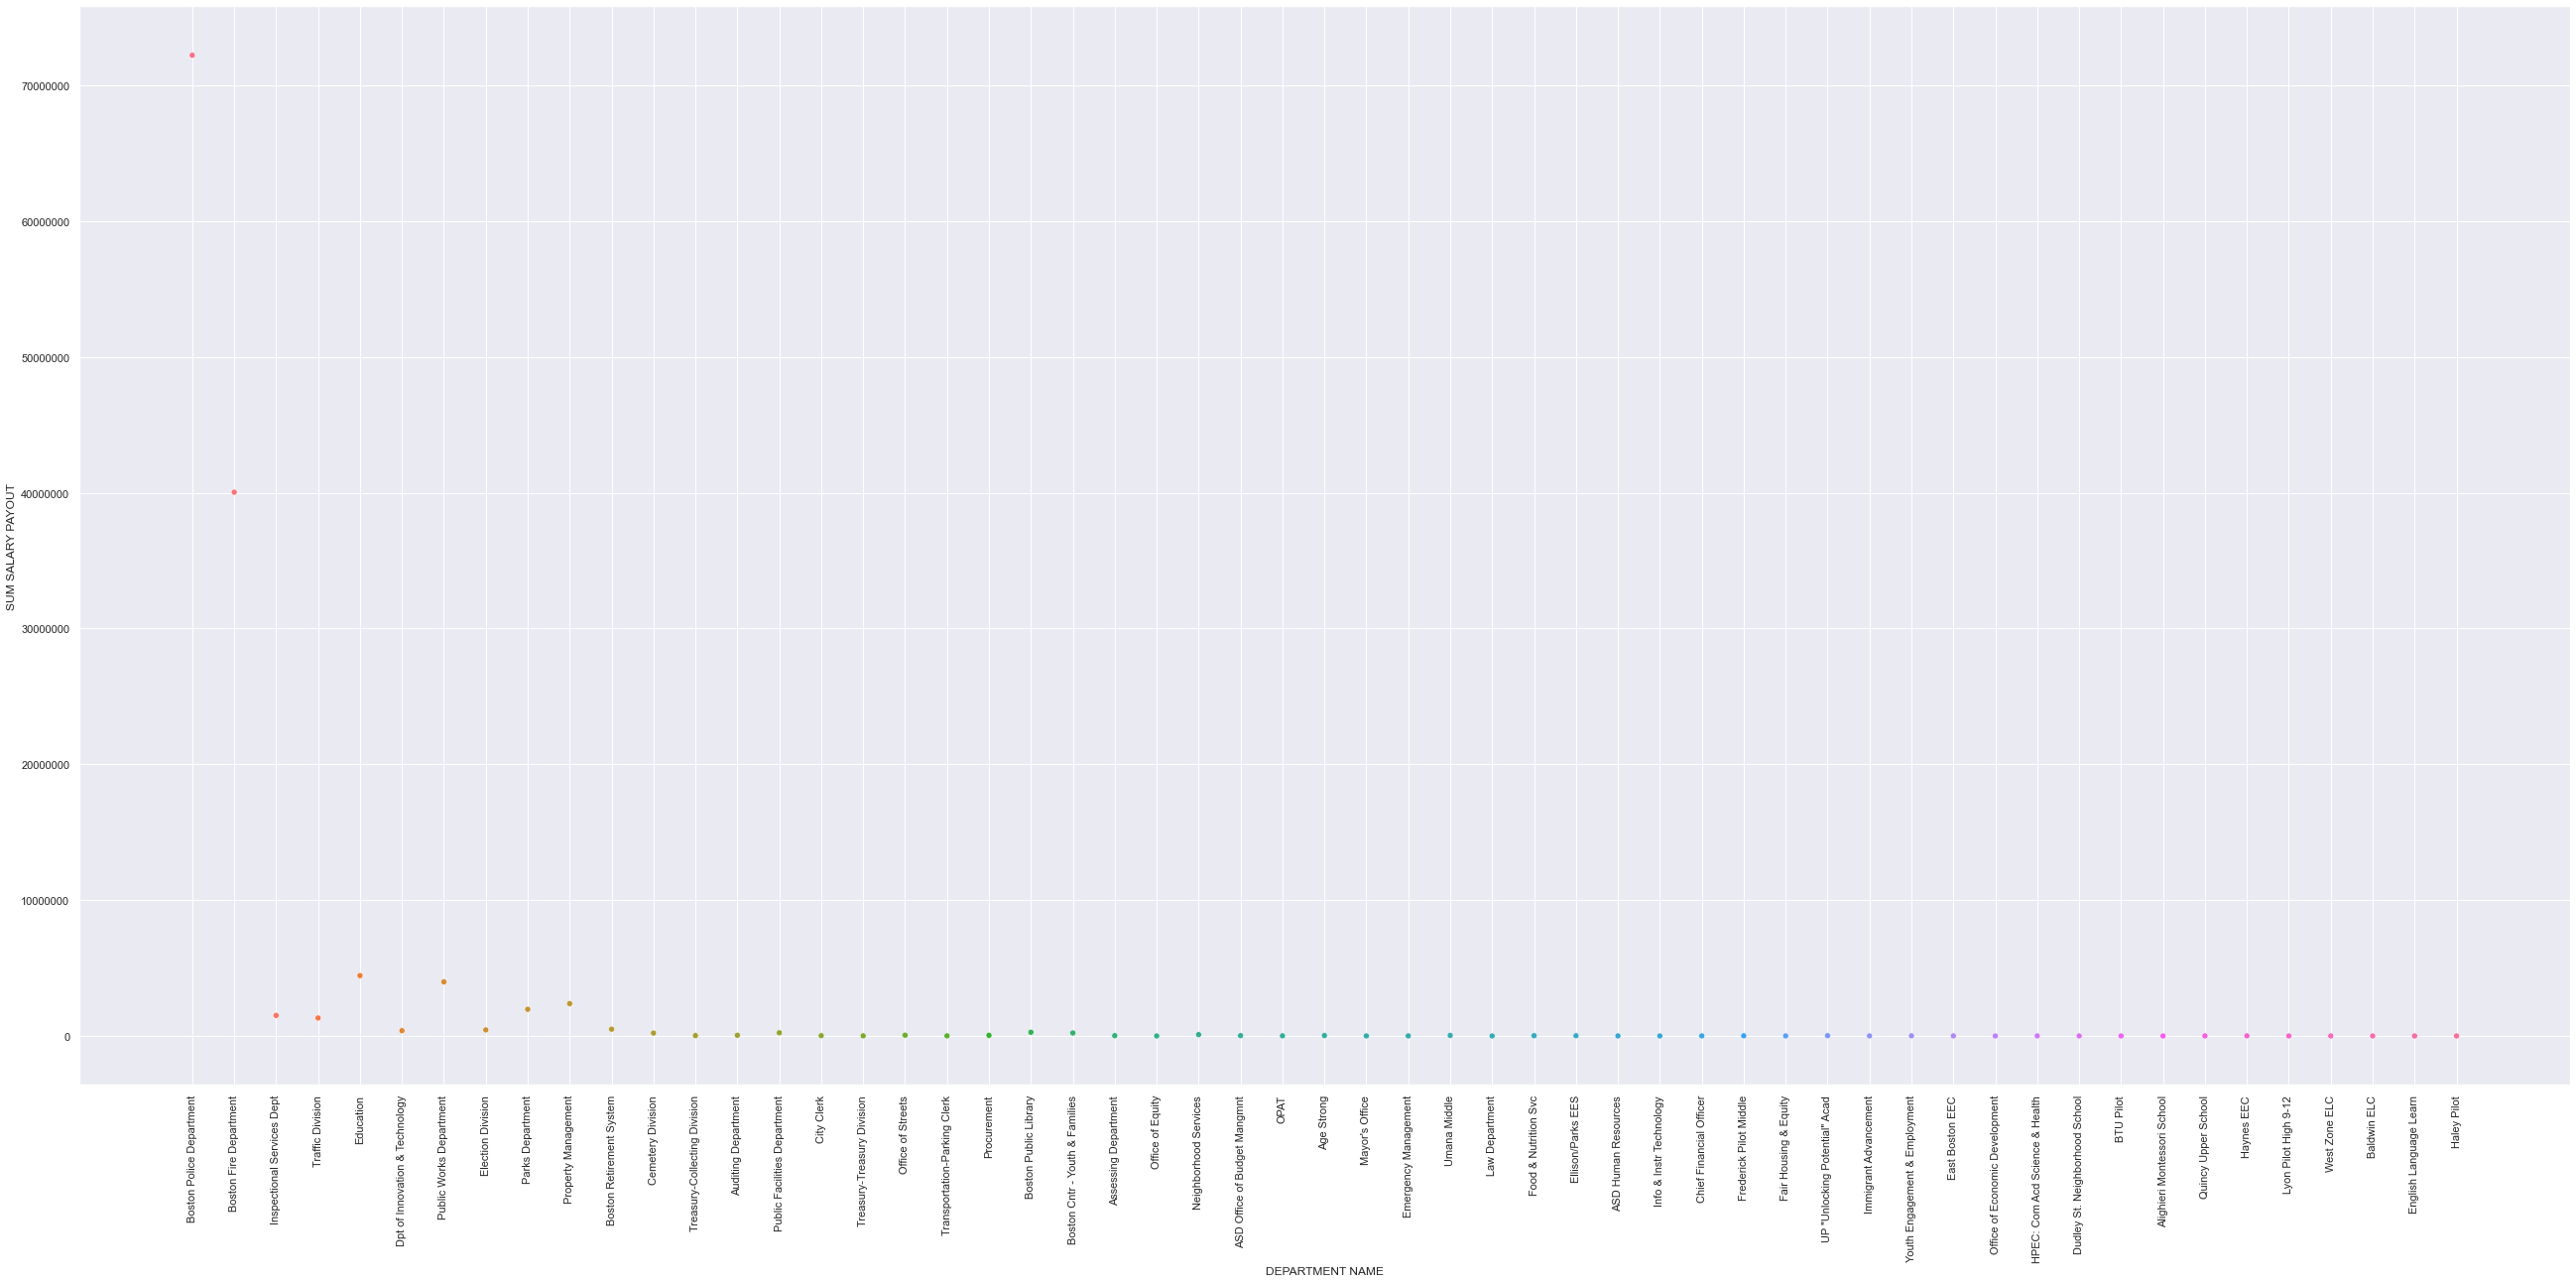

In [18]:
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(35,10)})
sns.scatterplot(data=our_cleaned_sum_dataframe, x="DEPARTMENT NAME", y="SUM SALARY PAYOUT", hue="DEPARTMENT NAME",legend = False)
plt.show()